# Convolutional and Variational Autoencoders

Typically, autoencoders don't work well with images unless they are very small. However, a convolutional neural network (CNN) works much better than a feedforward dense network with large color images. We demonstrate a convolutional autoencoder with a code example. We also demonstrate a variational encoder with a code example. Variational autoencoders are quite different from the other autoencoders in two ways. They are probabilistic because their outputs are partly determined by chance even after training. Most importantly, they are generative. That is, they can generate new instances that look like they were sampled from the training set.

# Import **tensorflow** library

Import library and alias it:

In [1]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is active:

In [2]:
tf.__version__, tf.test.gpu_device_name()

('2.4.1', '/device:GPU:0')

# Convolutional Autoencoders

Autoencoders won't work well with images unless they are very small. However, a convolutional neural network (CNN) works much better than feedforward dense networks with large color images. So let's use a dataset with large color images.

Resource:

https://codelabs.developers.google.com/codelabs/tensorflow-lab5-compleximages

## Horses or Humans Dataset

The **horses_or_humans** TFDS is a set of images of horses and humans.

Get data for inspection:

In [3]:
import tensorflow_datasets as tfds

data, hh_info = tfds.load(
    'horses_or_humans', with_info=True,
    split='train', try_gcs=True)

Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteXV9GD6/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteXV9GD6/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


Display metadata:

In [4]:
hh_info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    version=3.0.0,
    description='A large set of images of horses and humans.',
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1283,
    splits={
        'test': 256,
        'train': 1027,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
    redistribution_info=,
)

Get metadata:

In [5]:
class_labels = hh_info.features['label'].names
num_classes = hh_info.features['label'].num_classes
class_labels, num_classes

(['horses', 'humans'], 2)

## Show Examples

Use show_examples:

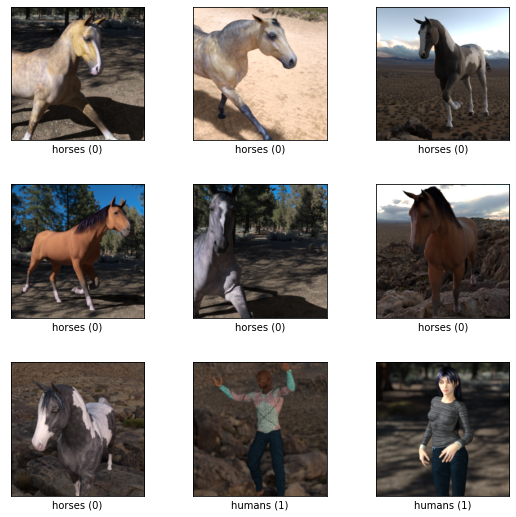

In [6]:
fig = tfds.show_examples(data, hh_info)

Convert to a pandas dataframe:

,image,label
0,,0 (horses)
1,,0 (horses)
2,,0 (horses)
3,,0 (horses)

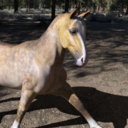
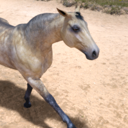
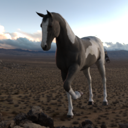
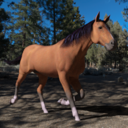

In [7]:
tfds.as_dataframe(data.take(4), hh_info)

Display an image manually:

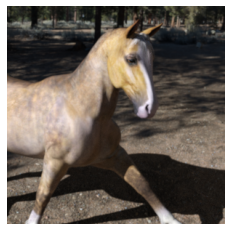

In [8]:
import matplotlib.pyplot as plt

for element in data.take(1):
  plt.imshow(element['image'])
  plt.axis('off')

Display a grid of images manually:

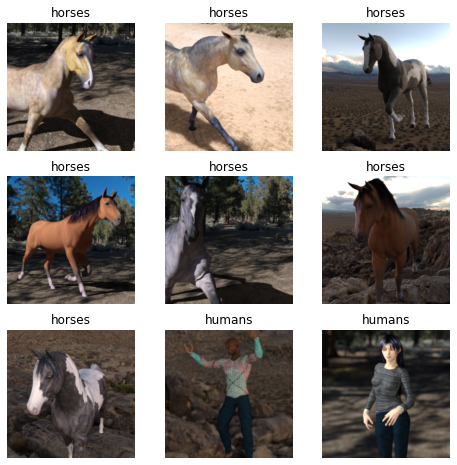

In [9]:
img, lbl = [], []
for element in data.take(9):
  img.append(element['image'])
  lbl.append(element['label'].numpy())
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(img[i-1])
  plt.title(class_labels[lbl[i-1]])
  plt.axis('off')
plt.show()

Create a set of images and labels. Plot the images and labels in a grid.

## Get Data for Training

Now that we have inspected the dataset and know its essence, we can load it for training:

In [10]:
(x_train_img, _), (x_test_img, _) = tfds.as_numpy(
    tfds.load(
        'horses_or_humans', split=['train','test'],
        batch_size=-1, as_supervised=True,
        try_gcs=True))

Since autoencoders are unsupervised models, we don't need the labels.

Get split information:

In [11]:
len(x_train_img), len(x_test_img)

(1027, 256)

## Inpsect Shapes

Display shape:

In [12]:
x_train_img.shape, x_test_img.shape

((1027, 300, 300, 3), (256, 300, 300, 3))

Check shapes of images:

In [13]:
for element in range(10):
  print (x_train_img.shape)

(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)
(1027, 300, 300, 3)


Since images are the same shape, we don't have to resize for training.

# Scale Images

Scale images by dividing by the number of pixels in an image:

In [14]:
import numpy as np

x_train, x_test = x_train_img.astype(np.float32) / 255,\
                  x_test_img.astype(np.float32) / 255

Inspect a vector from the train set to verify scaling:

In [15]:
x_train_img[0][0][0], x_train[0][0][0]

(array([53, 55, 45], dtype=uint8),
 array([0.20784314, 0.21568628, 0.1764706 ], dtype=float32))

## Clear Previous Models and Generate Seed

Clear previous model and generate a seed for reproducibility of results:

In [16]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Get input shape:

In [17]:
hh_shape = hh_info.features['image'].shape
hh_shape

(300, 300, 3)

## Create Encoder and Decoder

Import libraries:

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D,\
Dense, Flatten, Input, Conv2DTranspose
import matplotlib.pyplot as plt

Create encoder model:

In [19]:
conv_encoder = Sequential([
  Input(shape=hh_shape),
  Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
  MaxPool2D(pool_size=2),
  Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
  MaxPool2D(pool_size=2),
  Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
  MaxPool2D(pool_size=2)
])

The encoder is composed of convolutional layers and pooling layers. It reduces the spatial dimensionality of the inputs (height and width) while increasing the depth (number of feature maps).

Create the decoder model:

In [20]:
conv_decoder = Sequential([
  Conv2DTranspose(32, kernel_size=3, strides=2, padding='VALID',
                  activation='selu'),
  Conv2DTranspose(16, kernel_size=3, strides=2, padding='SAME',
                  activation='selu'),
  Conv2DTranspose(3, kernel_size=3, strides=2, padding='SAME',
                  activation='sigmoid')
])

The decoder must do the reverse of the encoder by upscaling images and reducing their depth back to original dimensions. We use Conv2DTranspose for this purpose.

## Create Convolutional Autoencoder

Create the autoencoder from the convolutional encoder and decoder:

In [21]:
conv_ae = Sequential([conv_encoder, conv_decoder])

## Compile

Create function for metric:

In [22]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(
        tf.round(y_true), tf.round(y_pred))

Compile model:

In [23]:
conv_ae.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1.0),
    metrics=[rounded_accuracy])

## Train

Train for five epochs:

In [24]:
cae_history = conv_ae.fit(
    x_train, x_train, epochs=5,
    validation_data=(x_test, x_test))

Epoch 1/5
33/33 [==============================] - 19s 95ms/step - loss: 0.6848 - rounded_accuracy: 0.5409 - val_loss: 0.3608 - val_rounded_accuracy: 0.9546
Epoch 2/5
33/33 [==============================] - 2s 74ms/step - loss: 0.5964 - rounded_accuracy: 0.8359 - val_loss: 0.4231 - val_rounded_accuracy: 0.9447
Epoch 3/5
33/33 [==============================] - 2s 74ms/step - loss: 0.5644 - rounded_accuracy: 0.9007 - val_loss: 0.3034 - val_rounded_accuracy: 0.9730
Epoch 4/5
33/33 [==============================] - 2s 74ms/step - loss: 0.5477 - rounded_accuracy: 0.9223 - val_loss: 0.2536 - val_rounded_accuracy: 0.9733
Epoch 5/5
33/33 [==============================] - 2s 74ms/step - loss: 0.5445 - rounded_accuracy: 0.9231 - val_loss: 0.2361 - val_rounded_accuracy: 0.9730


## Visualize Training Performance

Create a visualization function:

In [25]:
def viz_history(training_history):
  loss = training_history.history['loss']
  val_loss = training_history.history['val_loss']
  accuracy = training_history.history['rounded_accuracy']
  val_accuracy = training_history.history['val_rounded_accuracy']
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.title('Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(loss, label='Training set')
  plt.plot(val_loss, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.subplot(1, 2, 2)
  plt.title('Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(accuracy, label='Training set')
  plt.plot(val_accuracy, label='Test set', linestyle='--')
  plt.legend()
  plt.grid(linestyle='--', linewidth=1, alpha=0.5)
  plt.show()

Invoke:

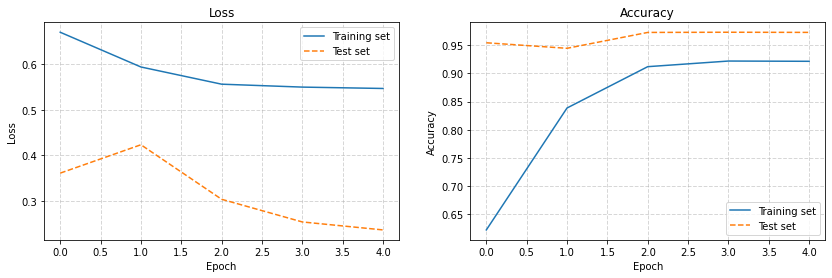

In [26]:
viz_history(cae_history)

## Visualize

Create function to show reconstructions:

In [27]:
def show_reconstructions(model, images, n_images, reshape=False):
  reconstructions = model.predict(images[:n_images])
  if reshape:
    reconstructions = tf.squeeze(reconstructions) # drop '1' dimension
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(images[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

Create function to show an image:

In [28]:
def plot_image(image):
  plt.imshow(image, cmap='binary')
  plt.axis('off')

Show images and reconstructions:

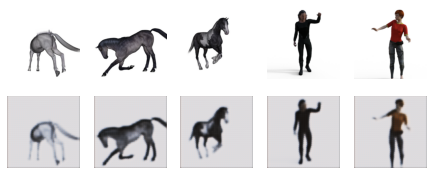

In [29]:
show_reconstructions(conv_ae, x_test, 5)

# Variational Autoencoders

Variational autoencoders are quite different from the other autoencoders in two ways. They are probabilistic because their outputs are partly determined by chance even after training. Most importantly, they are generative. That is, they can generate new instances that look like they were sampled from the training set.

## How Variational Autoencoders Work

Instead of directly producing a coding (latent representation) for a given input, the endocder produces a mean coding $u$ and a standard deviation $\sigma$. The actual coding is then sampled randomly from a Gaussian distribution with mean $u$ and standard deviatino $\sigma$. The decoder then decodes the sampled coding normally.

# Wonderful Resources

https://blog.tensorflow.org/2019/03/variational-autoencoders-with.html

https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE

https://www.tensorflow.org/probability/overview

## Load Fashion-MNIST Data

Load train and test feature images:

In [32]:
(x_train_fm, _), (x_test_fm, _) = tfds.as_numpy(
    tfds.load('fashion_mnist', split=['train','test'],
              batch_size=-1, as_supervised=True,
              try_gcs=True))

## Get Input Shape

Get shape of images:

In [33]:
x_train_fm.shape, x_test_fm.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Get input shape for encoder and decoder:

In [34]:
fmnist_shape = x_train_fm.shape[1:]
fmnist_shape

(28, 28, 1)

## Scale

Scale feature images by dividing by the number of pixels in each image:

In [35]:
x_train_fds, x_test_fds = x_train_fm.astype(np.float32) / 255,\
                          x_test_fm.astype(np.float32) / 255

## Create a Custom Layer to Sample Codings

The sampling layer takes two inputs: mean $u$ and log variance $y$. It uses function tf.random.normal() to sample a random vector of the same shape as $y$ from the normal distribution with mean 0 ($u$ = 0) and standard deviation 1 ($\sigma$ = 1), multiplies it by $exp(y/2$), adds $u$, and returns the result.

In [36]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return tf.random.normal(tf.shape(log_var)) *\
           tf.math.exp(log_var / 2) + mean

## Clear Models and Generate Seed

Clear previous models and seed for reproducibility of results:

In [38]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Create the Encoder

Use the Functional API because the model isn't entirely sequential:

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape

codings_size = 10

inputs = Input(shape=fmnist_shape)
z = Flatten()(inputs)
z = Dense(128, activation='relu')(z)
z = Dense(64, activation='relu')(z)
z = Dense(32, activation='relu')(z)
codings_mean = Dense(codings_size)(z)
codings_log_var = Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = Model(
    inputs=[inputs],
    outputs=[codings_mean, codings_log_var, codings])

The Dense layers output codings_mean $u$ and codings_log_var $y$ that both have the same inputs (i.e., the outputs of the second Dense layer). Both codings_mean and codings_log_var are then passed to the Sampling layer. The variational_encoder has three outputs, namely, codings_mean, codings_log_var, and codings. But, we only use the **codings** output.

## Create the Decoder

Create the variational decoder:

In [40]:
decoder_inputs = Input(shape=[codings_size])
x = Dense(32, activation='relu')(decoder_inputs)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(28 * 28, activation='sigmoid')(x)
outputs = Reshape(fmnist_shape)(x)
variational_decoder = Model(
    inputs=[decoder_inputs], outputs=[outputs])

We could have used the Sequential API instead of the Functional API since it is really just a simple stack of layers.

## Build the Variational Encoder Model

Create the autoencoder from the variational encoder and decoder:

In [41]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = Model(
    inputs=[inputs], outputs=[reconstructions])

We ignore the first two outputs because we only need the codings.

## Add Latent Loss and Reconstruction Loss to the Model

Compute latent loss as 1 plus codings_log_var minus the exponential of codings_log_var minus the square of codings_mean. Multiply this result by -0.5. Compute reconstruction loss as mean loss over all instances in the batch and divide by 784 to ensure appropriate scale.

In [42]:
latent_loss = -0.5 * tf.math.reduce_sum(
    1 + codings_log_var - tf.math.exp(codings_log_var) -\
    tf.math.square(codings_mean), axis=-1)

variational_ae.add_loss(
    tf.math.reduce_mean(latent_loss) / 784.)

## Compile

Compile with **binary crossentropy** and **rmsprop** loss:

In [43]:
variational_ae.compile(
    loss='binary_crossentropy', optimizer='rmsprop',
    metrics=[rounded_accuracy])

## Train

Train for ten epochs:

In [44]:
vae_history = variational_ae.fit(
    x_train_fds, x_train_fds, epochs=10,
    batch_size=128,
    validation_data=(x_test_fds, x_test_fds))

Epoch 1/10
469/469 [==============================] - 3s 5ms/step - loss: 0.4407 - rounded_accuracy: 0.7962 - val_loss: 0.3678 - val_rounded_accuracy: 0.8704
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3539 - rounded_accuracy: 0.8807 - val_loss: 0.3414 - val_rounded_accuracy: 0.8936
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3385 - rounded_accuracy: 0.8961 - val_loss: 0.3343 - val_rounded_accuracy: 0.8991
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3322 - rounded_accuracy: 0.9003 - val_loss: 0.3327 - val_rounded_accuracy: 0.8978
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 0.3281 - rounded_accuracy: 0.9035 - val_loss: 0.3259 - val_rounded_accuracy: 0.9059
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3248 - rounded_accuracy: 0.9066 - val_loss: 0.3259 - val_rounded_accuracy: 0.9084
Epoch 7/10
469/469 [==============================] 

Visualize:

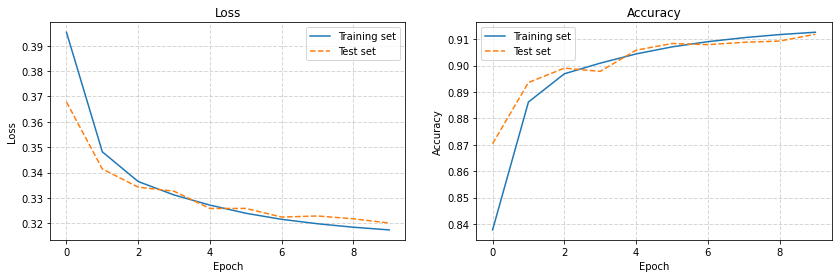

In [45]:
viz_history(vae_history)

## Visualize

Inspect the shape of the test set:

In [47]:
x_test_fds.shape

(10000, 28, 28, 1)

Remove the '1' dimension:

In [48]:
x_test_fds_imgs = tf.squeeze(x_test_fds)
x_test_fds_imgs.shape

TensorShape([10000, 28, 28])

Visualize:

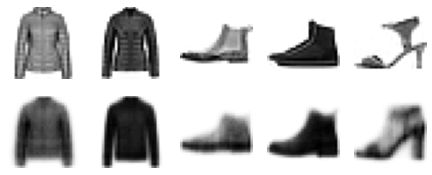

In [49]:
show_reconstructions(
    variational_ae, x_test_fds_imgs, 5, reshape=True)

# Generate Fashion-MNIST Images

Create a plotting function:

In [50]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

Generate a few random codings, decode them, and plot the resulting images:

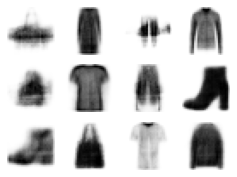

In [51]:
tf.random.set_seed(0)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

Notice that we used the **variational_decoder**.

Perform semantic interpolation between these images:

In [52]:
tf.random.set_seed(0)
np.random.seed(0)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(
    larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()
images.shape

(35, 28, 28, 1)

To display images, remove the '1' dimension:

In [54]:
images = tf.squeeze(images)

Visualize:

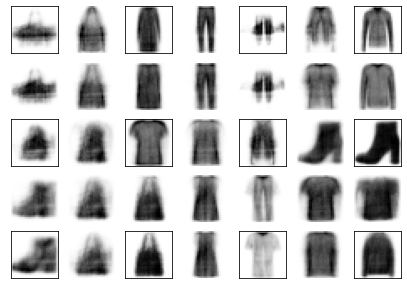

In [55]:
plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
  plt.subplot(5, 7, index + 1)
  if index%7%2==0 and index//7%2==0:
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
  else:
    plt.axis('off')
  plt.imshow(image, cmap='binary')

# TensorFlow Probability Layers

Fit a Variational Autoencoder using TensorFlow Probability Layers.

## Load and Process Train and Test Data

Load Fashion-MNIST, preprocess, and map the input pipeline:

In [109]:
fmnist, fmnist_info = tfds.load(
    name='fashion_mnist', try_gcs=True,
    with_info=True, as_supervised=False)

def _preprocess(sample):
  image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
  image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
  return image, image

auto = tf.data.experimental.AUTOTUNE
BATCH_SIZE, SHUFFLE_SIZE = 256, int(10e3)

train_tpl = (fmnist['train']
             .map(_preprocess)
             .batch(BATCH_SIZE)
             .prefetch(auto)
             .shuffle(SHUFFLE_SIZE))
test_tpl = (fmnist['test']
            .map(_preprocess)
            .batch(BATCH_SIZE)
            .prefetch(auto))

## Inspect

Inspect a slice from a batch:

In [110]:
for example in train_tpl.take(1):
  print (example[0][0][0][0:15])
  print (example[0].shape)

tf.Tensor(
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]], shape=(15, 1), dtype=bool)
(256, 28, 28, 1)


Inspect the shape of a batch:

In [111]:
for row in train_tpl.take(1):
  print (row[0].shape)

(256, 28, 28, 1)


## Create the TPL VAE

Create a TFP independent Gaussian distribution with no learned parameters. The latent variable, z has 16 dimensions.

In [112]:
import tensorflow_probability as tfp

tfd = tfp.distributions
encoded_size = 16
prior = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros(encoded_size), scale=1),
        reinterpreted_batch_ndims=1)

Get the input shape and base depth:

In [113]:
input_shape = fmnist_info.features['image'].shape
base_depth = 32
input_shape

(28, 28, 1)

Assign aliases for convenience:

In [114]:
tfpl = tfp.layers
tfd = tfp.distributions
leaky = tf.nn.leaky_relu

Create an encoder with a full-covariance Gaussian distribution with mean and covariance matrices parameterized by the output of a neural network. TFP layers enables contruction of this complex encoder very easy.

In [115]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras.layers import InputLayer, Lambda

encoder = Sequential([
  InputLayer(input_shape=input_shape),
  Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
  Conv2D(base_depth, 5, strides=1, padding='same',
         activation=leaky),
  Conv2D(base_depth, 5, strides=2, padding='same',
         activation=leaky),
  Conv2D(base_depth * 2, 5, strides=1,
         padding='same', activation=leaky),
  Conv2D(base_depth * 2, 5, strides=2, padding='same',
         activation=leaky),
  Conv2D(4 * encoded_size, 7, strides=1, padding='valid',
         activation=leaky),
  Flatten(),
  Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),
        activation=None),
  tfpl.MultivariateNormalTriL(
      encoded_size,
      activity_regularizer=tfpl.KLDivergenceRegularizer(
          prior, weight=1.0))
])

The encoder is a normal Keras Sequential model with convolutions and dense layers. But the output is passed to a TFP Layer (MultivariateNormalTril()), which transparently splits the activations from the final Dense layer into the parts needed to specify both the mean and the (lower triangular) covariance matrix (the parameters of a Multivariate Normal). We use the tfpl helper MultivariateNormalTriL.params_size(encoded_size) to make the Dense layer output the correct number of activations (i.e., the distribution’s parameters). We also contribute a regularization term to the final loss. Specifically, we add the KL divergence between the encoder and the prior to the loss, which is the KL term in the ELBO that we described above.

Create the decoder as a pixel-independent Bernoulli distribution:

In [116]:
decoder = Sequential([
  InputLayer(input_shape=[encoded_size]),
  Reshape([1, 1, encoded_size]),
  Conv2DTranspose(2 * base_depth, 7, strides=1,
                  padding='valid', activation=leaky),
  Conv2DTranspose(2 * base_depth, 5, strides=1,
                  padding='same', activation=leaky),
  Conv2DTranspose(2 * base_depth, 5, strides=2,
                  padding='same', activation=leaky),
  Conv2DTranspose(base_depth, 5, strides=1,
                  padding='same', activation=leaky),
  Conv2DTranspose(base_depth, 5, strides=2,
                  padding='same', activation=leaky),
  Conv2DTranspose(base_depth, 5, strides=1,
                  padding='same', activation=leaky),
  Conv2D(filters=1, kernel_size=5, strides=1,
         padding='same', activation=None),
  Flatten(),
  tfpl.IndependentBernoulli(
      input_shape, tfd.Bernoulli.logits)
])

The form here is essentially the same as the encoder, but now we are using transposed convolutions to take our latent representation (a 16-dimensional vector) and turn it into a 28 x 28 x 1 tensor. That final layer parameterizes the pixel-independent Bernoulli distribution.

Build the full model:

In [118]:
from tensorflow.keras import Model

tpl_vae = Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

Check that the inputs are created appropriately:

In [119]:
encoder.inputs

[<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'input_11')>]

Compile with appropriate loss and train:

In [121]:
lr = 1e-3
lr

0.001

In [122]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

tpl_vae.compile(
    optimizer=tf.optimizers.Adam(learning_rate=lr),
    loss=negloglik)

_ = tpl_vae.fit(train_tpl, epochs=15,
                validation_data=test_tpl)

Epoch 1/15
235/235 [==============================] - 14s 35ms/step - loss: 404.5653 - val_loss: 272.0257
Epoch 2/15
235/235 [==============================] - 12s 32ms/step - loss: 268.1445 - val_loss: 264.9402
Epoch 3/15
235/235 [==============================] - 11s 32ms/step - loss: 260.9524 - val_loss: 261.3123
Epoch 4/15
235/235 [==============================] - 11s 32ms/step - loss: 258.8994 - val_loss: 258.8719
Epoch 5/15
235/235 [==============================] - 12s 32ms/step - loss: 256.9430 - val_loss: 257.7128
Epoch 6/15
235/235 [==============================] - 12s 33ms/step - loss: 255.5371 - val_loss: 256.5502
Epoch 7/15
235/235 [==============================] - 11s 32ms/step - loss: 255.6354 - val_loss: 256.2622
Epoch 8/15
235/235 [==============================] - 11s 32ms/step - loss: 254.4840 - val_loss: 255.6685
Epoch 9/15
235/235 [==============================] - 12s 32ms/step - loss: 253.8620 - val_loss: 255.9456
Epoch 10/15
235/235 [=========================

Our model is just a Keras Model where the outputs are defined as the composition of the encoder and the decoder. Since the encoder already added the KL term to the loss, we need to specify only the reconstruction loss.

## Efficacy Test 

In [140]:
# We'll just examine ten random digits.
x = next(iter(test_tpl))[0][:10]
xhat = tpl_vae(x)
assert isinstance(xhat, tfd.Distribution)

In [141]:
def display_imgs(x, y=None):
  if not isinstance(x, (np.ndarray, np.generic)):
    x = np.array(x)
  plt.ioff()
  n = x.shape[0]
  fig, axs = plt.subplots(1, n, figsize=(n, 1))
  if y is not None:
    fig.suptitle(np.argmax(y, axis=1))
  for i in range(n):
    axs.flat[i].imshow(x[i].squeeze(),
                       interpolation='none',
                       cmap='gray')
    axs.flat[i].axis('off')
  plt.show()
  plt.close()

Originals:


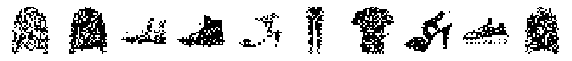

Decoded Random Samples:


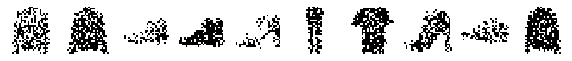

Decoded Modes:


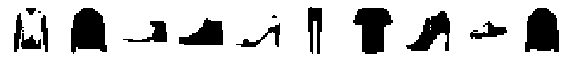

Decoded Means:


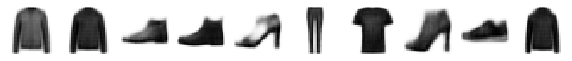

In [142]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())